# Step 1: Data Munging
## Initial Setup and Data Exploration

### Load data and necessary packages

In [159]:
# Import the necessary libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pandas as pd
import numpy as np
import sklearn
import random as random
random.seed(5)
import statsmodels.api as sm
import statsmodels as sms

In [110]:
# load file and pandas data frame
data = pd.read_csv("data_assignment.csv", sep = ",", header = 0)

### Inspect data set for any missing/corrupted data

In [111]:
# look at sample rows
data.head()

,Success,Model_B,Date,X1,X2,X3,X4
0,0,0.320440,2018-07,0,-0.897088,0.804294,0.707665
1,0,0.491581,2018-09,1,-0.328084,-0.332256,-0.340870
2,0,0.085481,2015-08,0,1.272140,2.243532,0.815581
3,1,0.839927,2017-07,1,0.290594,-1.161187,-0.881761
4,0,0.146804,2018-09,0,-0.307462,1.161276,1.597084


In [112]:
# inspect data
data.describe()

,Success,Model_B,X1,X2,X3,X4
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,0.155667,0.493951,0.502167,-0.003326,0.007374,0.015992
std,0.362569,0.209031,0.500037,1.004197,1.012626,1.013181
min,0.000000,0.021030,0.000000,-3.612620,-4.860280,-4.416066
25%,0.000000,0.330084,0.000000,-0.702663,-0.673058,-0.662022
50%,0.000000,0.491583,1.000000,-0.001634,0.015458,0.020163
75%,0.000000,0.657086,1.000000,0.685290,0.681624,0.681972
max,1.000000,0.988474,1.000000,3.896294,3.852129,3.641890


In [113]:
# look for any missing data
data.isna().sum()

Success    0
Model_B    0
Date       0
X1         0
X2         0
X3         0
X4         0
dtype: int64

__Notes:__
- 'Success' has a mean of .1557 means that 15.57% of emails are successful 
- 'Model_B' has a mean of .4940. If the Model_B value is expected to be a value would imply the probability of success is centered around 49.40%. This being so different from the mean of 'Success' implies 'Model_B' would be a terrible model if optimized for accuracy. 
- X1 appears to be categorical. 
- X2,X3,X4 seem to have distributions with long tails. We will check for outliers.
- We don't have any missing data.

### Look at distributions within columns

In [114]:
# check to make sure that 'Success' is either 0 or 1 and look for class balance
data['Success'].value_counts()

0    5066
1     934
Name: Success, dtype: int64

We have an unblanaced classification problem. We will have to consider addressing this in training our new model.

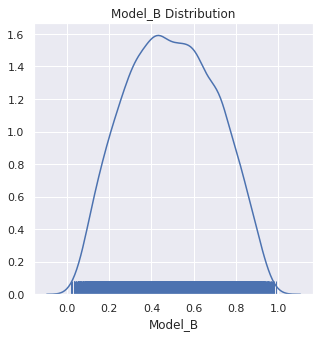

In [162]:
# look at distributin of Model_B scores

fig, sub = plt.subplots(1, 1, figsize = (5, 5))

sns.distplot(data['Model_B'], hist=False, rug=True)
sub.title.set_text('Model_B Distribution')

This is very odd because Model_B scores seem to be evenly distributed around .5. 

In [166]:
# looks like 'X1' is categorical so look for counts
data['X1'].value_counts()

1    3013
0    2987
Name: X1, dtype: int64

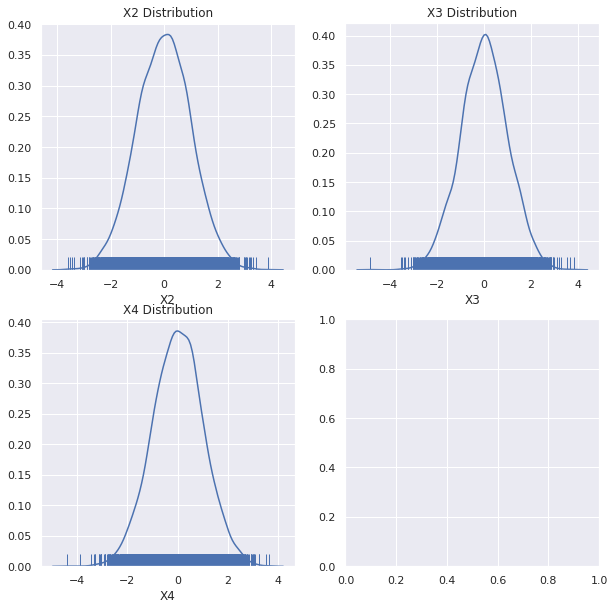

In [160]:
# look at distributions of X2,X3,X4

fig, sub = plt.subplots(2, 2, figsize = (10, 10))

sns.distplot(data['X2'], hist=False, rug=True, ax=sub[0,0])
sub[0,0].title.set_text('X2 Distribution')

sns.distplot(data['X3'], hist=False, rug=True, ax=sub[0,1])
sub[0,1].title.set_text('X3 Distribution')

sns.distplot(data['X4'], hist=False, rug=True, ax=sub[1,0])
sub[1,0].title.set_text('X4 Distribution')

Notes:
X1 is categorical.
X2,X3,X4 seem to be sampled for some normal like distributions so no clear outliers. 

In [118]:
#Add a datetime column just for easy manipulation
data['DateTime'] = pd.to_datetime(data['Date'], format='%Y-%m')

In [119]:
#extract month and year so we can look at seasonality
data['Year'] = data['DateTime'].apply(lambda x: x.year)
data['Month'] = data['DateTime'].apply(lambda x: x.month)

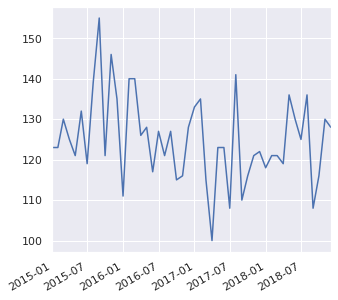

In [163]:
# look for distribution of date
fig, sub = plt.subplots(1, 1, figsize = (5, 5))
data['DateTime'].value_counts().plot(kind='line')

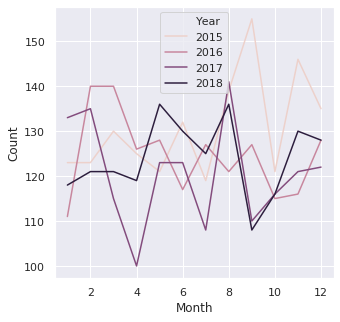

In [164]:
# look for seasonality
fig, sub = plt.subplots(1, 1, figsize = (5, 5))
seasonality = data.groupby(['Month','Year']).size().reset_index()
seasonality.columns = ['Month','Year','Count']
sns.lineplot(data=seasonality,x ='Month', y='Count',hue='Year')

No clear 'Seasonality' in emails sent.

## Look at relationships between features and 'Success'

### Model B and Success
This is shown in __Step 3: Model Evaluation__

### X1 and Success

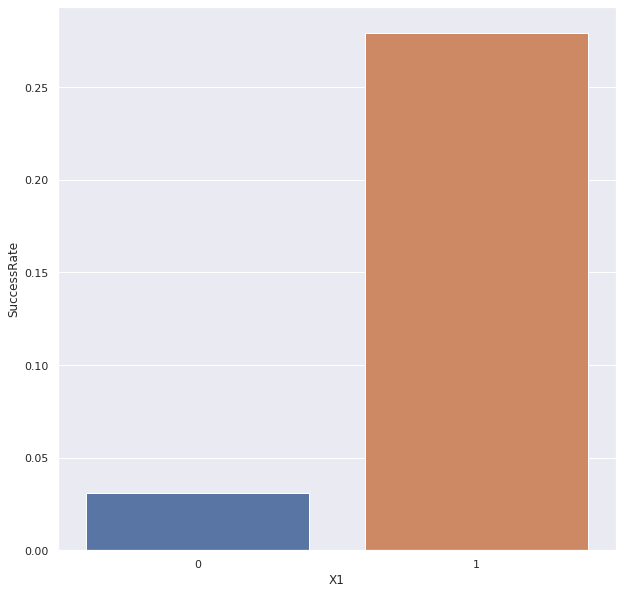

In [122]:
# for categorical variable like X1 we look at percent success by category
X1successRate = data[['Success','X1']].groupby('X1').agg(np.mean).reset_index()
X1successRate = X1successRate.rename(columns = {'Success':'SuccessRate'})
X1successRate
fig, sub = plt.subplots(1, 1, figsize = (10, 10))
sns.barplot(data=X1successRate, x='X1', y='SuccessRate')

__Notes:__
- Emails with X1=1 are ~7 times as likely to be successful.

### X2,X3,X4 and Success

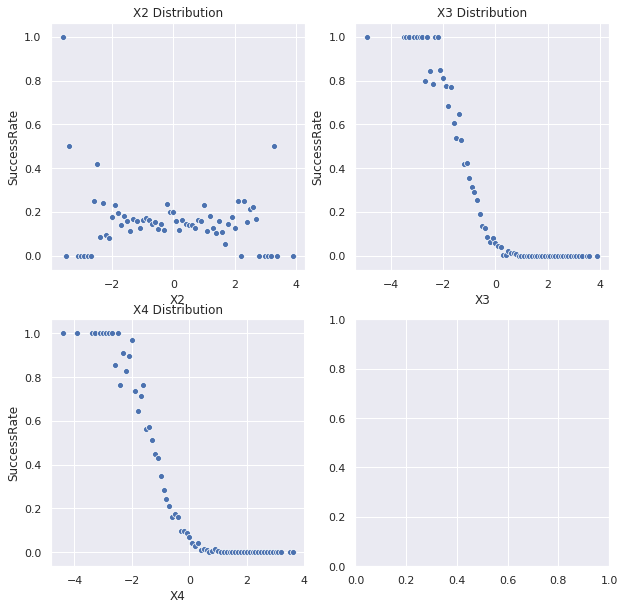

In [165]:
variables = ['X2','X3','X4']
fig, sub = plt.subplots(2, 2, figsize = (10, 10))
i=0

for v in variables:
    df = pd.DataFrame({v: data[v].apply(lambda x:np.round(x,1)),'SuccessRate':data['Success']})
    df = df.groupby(v).agg(np.mean).reset_index()
    sns.scatterplot(df[v],df['SuccessRate'],ax=sub[i//2,(i%2)])
    sub[i//2,(i%2)].title.set_text(v+' Distribution')
    i+=1
    
plt.show()

__Notes:__
- X2 seems to have minimal relationship to SuccessRate
- X3 and X4 seem to have strong sigmoidal? relationship with SuccessRate

### Date and Success

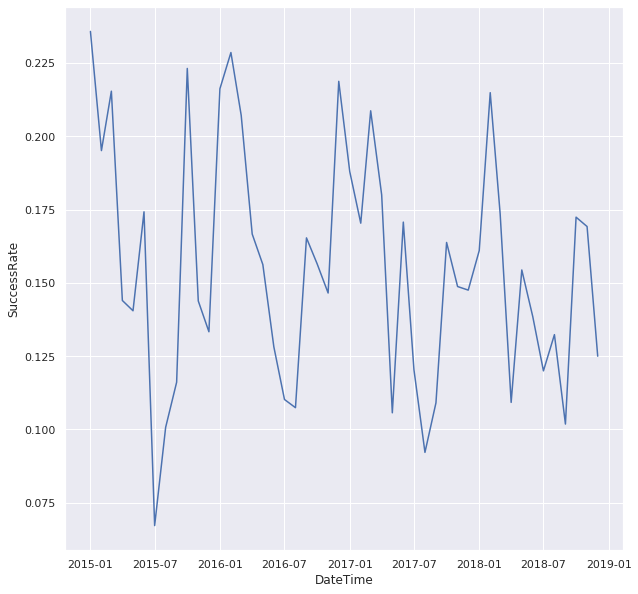

In [124]:
# look for success rate across time
fig, sub = plt.subplots(1, 1, figsize = (10, 10))
ts = data[['DateTime','Success']].groupby('DateTime').agg(np.mean).reset_index()
ts.columns = ['DateTime','SuccessRate']
sns.lineplot(data = ts, x = 'DateTime', y= 'SuccessRate')

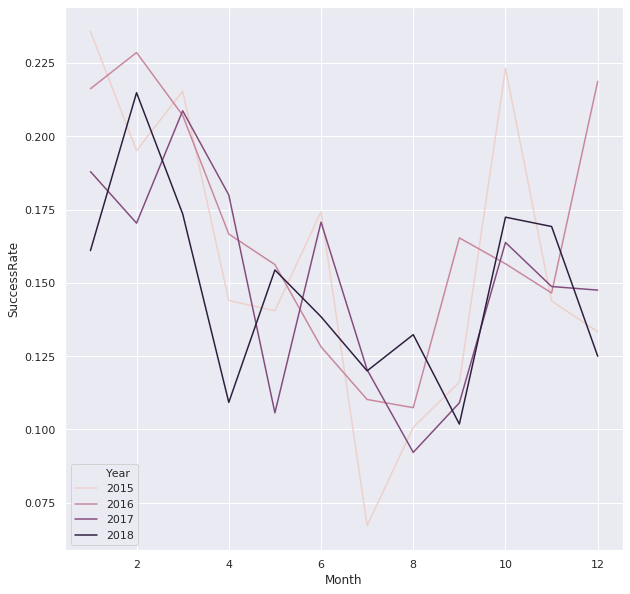

In [125]:
# look for success rate by seasonality
fig, sub = plt.subplots(1, 1, figsize = (10, 10))
ts = data[['Year','Month','Success']].groupby(['Year','Month']).agg(np.mean).reset_index()
ts.columns = ['Year','Month','SuccessRate']
sns.lineplot(data = ts, x = 'Month', y= 'SuccessRate', hue='Year')

There appears to be some seasonality in success rate with lows in summer and highs in winter.

# Step 2: Build a new Model

## Model Selection

We have a binary classification problem. We can either create a model that outputs a prediction (0 or 1) or that outputs a probability. In the spirit of Model_B we create a model that outputs a probability. 

We do this by applying a gradient boosting decision tree. We take a random 20% holdout test set, and perform grid search with cross validation on the remaining data set. We train without date, but with month. 

In [126]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_curve

X_train, X_test, y_train, y_test = train_test_split(data[['Model_B','X1','X2','X3','X4','Month']], data['Success'], 
                                                    test_size=0.2, random_state=28)

gbdt = GradientBoostingRegressor(random_state=11)


param_grid = {
                 'n_estimators': [3, 7, 12],
                 'max_depth': [2, 5, 9]
             }


grid_gbdt = GridSearchCV(gbdt, param_grid, cv=5)
grid_gbdt.fit(X_train, y_train)
model_A = grid_gbdt.best_estimator_

# Step 3: Model Evaluation

If we interpret Model_B as a probability of success, we can compare the mean squared errors between the models on the test sets.

In [127]:
print('Model_A has mean squared error (on test set) of {}.'.format(mean_squared_error(y_test, model_A.predict(X_test))))
print('Model_B has mean squared error (on test set) of {}.'.format(mean_squared_error(y_test, X_test['Model_B'])))

Model_A has mean squared error (on test set) of 0.047967550274427166.
Model_B has mean squared error (on test set) of 0.19607534913292599.


In [128]:
thresholds = np.arange(.01,1,.01)
model_A_test_probs = model_A.predict(X_test)
model_B_test_probs = np.array(X_test['Model_B'])

In [130]:
precA, recA, thresholdsA = precision_recall_curve(y_test,model_A_test_probs)
thresholdsA = np.concatenate([thresholdsA, np.array([1])])
precB, recB, thresholdsB = precision_recall_curve(y_test,model_B_test_probs)
thresholdsB = np.concatenate([thresholdsB, np.array([1])])

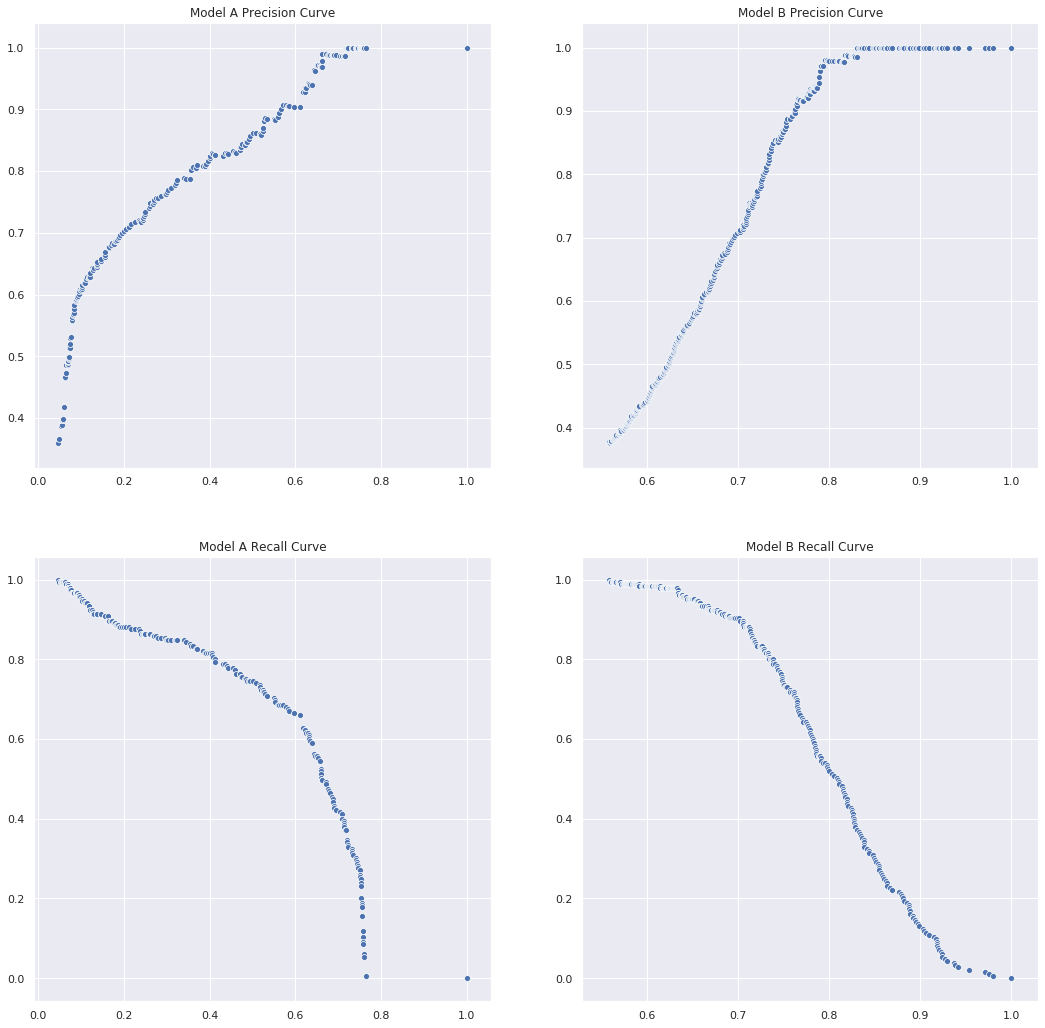

In [131]:
fig, sub = plt.subplots(2, 2, figsize = (18, 18))

sns.scatterplot(x=thresholdsA, y=precA,ax = sub[0,0])
sub[0,0].title.set_text('Model A Precision Curve')

sns.scatterplot(x=thresholdsB, y=precB,ax = sub[0,1])
sub[0,1].title.set_text('Model B Precision Curve')

sns.scatterplot(x=thresholdsA, y=recA,ax = sub[1,0])
sub[1,0].title.set_text('Model A Recall Curve')

sns.scatterplot(x=thresholdsB, y=recB,ax = sub[1,1])
sub[1,1].title.set_text('Model B Recall Curve')


# Step 4: Conclusion

### Quick aside on Model A adjustment for business case

Knowing the business case, we should not have optimized our model by minimizing the squared loss and instead have minimized a loss function something like $$\sum .01*yhat*(1-y) + .24*(1-yhat)*y$$.

We can modify Model A to optimize for this by finding the threshold that minimizes the above equation. More properly I would have changed the loss function when trainnig my model or __upsampled__ positive samples by a factor f 24 and used a absolute loss loss function. 

We do that now (to both Model_A and Model_B). 

In [156]:
# prepare profit and loss metrics at thresholds

def loss_for_A(t):
    return np.sum(.01*(1-y_test)*np.floor(model_A_test_probs+(1-t)) + 
                  .24*y_test*(1-np.floor(model_A_test_probs+(1-t))))

def profit_for_A(t):
    return np.sum(-.01*(1-y_test)*np.floor(model_A_test_probs+(1-t)) + 
                  .24*y_test*(np.floor(model_A_test_probs+(1-t))))

lfA = np.vectorize(loss_for_A)
pfA = np.vectorize(profit_for_A)

Aloss = lfA(thresholdsA)
A_index = np.argmin(Aloss)
Aprofit = pfA(thresholdsA)

def loss_for_B(t):
    return np.sum(.01*(1-y_test)*np.floor(model_B_test_probs+(1-t)) + 
                  .24*y_test*(1-np.floor(model_B_test_probs+(1-t))))

def profit_for_B(t):
    return np.sum(-.01*(1-y_test)*np.floor(model_B_test_probs+(1-t)) + 
                  .24*y_test*(np.floor(model_B_test_probs+(1-t))))

lfB = np.vectorize(loss_for_B)
pfB = np.vectorize(profit_for_B)

Bloss = lfB(thresholdsB)
Bprofit = pfB(thresholdsB)
B_index = np.argmin(Bloss)

In [157]:
# print results
print('''The best case for model A is to use a threshold of {}, 
      with which we miss optimal profit on the test set by {} (for 
      a total profit of {}).'''.format(thresholdsA[A_index], Aloss[A_index], Aprofit[A_index])) 

print('''The best case for model B is to use a threshold of {}, 
      with which we miss optimal profit on the test set by {} (for 
      a total profit of {}).'''.format(thresholdsB[B_index], Bloss[B_index], Bprofit[B_index])) 

The best case for model A is to use a threshold of 0.06323960479506713, 
      with which we miss optimal profit on the test set by 2.35 (for 
      a total profit of 42.05).
The best case for model B is to use a threshold of 0.6334321951994097, 
      with which we miss optimal profit on the test set by 2.5 (for 
      a total profit of 41.89999999999999).


### Executive Summary

We should switch to using Model_A, but with a very aggressive approach.

By aggressive approach, I mean that we should send out an email even if Model_A only gives a slight chance (at least 6.3%) to the email being successful. This is because the cost of sending out a useless email is small (just 1 cent of loss) whereas the cose of not sending out an email that would have been successful is relatively high (missing out on 24 cents of profit).

Our recommendation is with low confidence however. In our testing, our aggressive application of model A increased profits by just ~0.36%. This is a very small improvement and in fact might simply just be random chance (it amounts to just on more successful email campaign in our test set). Further we should consider the cost of the added complexity and performance costs of the model.